Using the cluster_feats saved in each country's results folder, we will finally predict the metric of interest (consumption per capita). There are many ways to evaluate our results, I do the following: <br>
1) randomized CV (=Cross validation) - use 5-fold cross validation randomly on all clusters, all countries <br>
2) randomized CV per country - use 5-fold cross validation within a country for all countries <br>
3) spatial CV per country - use 5-fold cross validation but folds consist of clusters that are geographically close <br>
4) cross-country CV - we have three countries, so hold one country out and perform cross validation <br>

Jean et al use the 2nd evaluation method. One important point: in their code, they use pearson R and square it to get R^2. The more conventional way is shown here: https://en.wikipedia.org/wiki/Coefficient_of_determination. I use the latter method, as in my experience this is standard for reporting R^2. Jean et al's method will likely lead to a higher "R^2" than the conventional method, and doing so prevents a negative R^2 whereas the conventional method allows that possibility.

Cross Validation means that each time, a different subset of the training data is used to train and the remaining to validate

In [11]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt


In [12]:
BASE_DIR = '..'

RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

In [13]:
import sys
sys.path.append(BASE_DIR)
from utils import merge_on_lat_lon, assign_groups, run_randomized_cv, run_spatial_cv

# Predict Consumption

In [14]:
def load_country(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features
    Returns the cluster features and the organized dataframe
    '''
    country_processed_dir = os.path.join(COUNTRIES_DIR, country, 'processed')
    country_results_dir = os.path.join(RESULTS_DIR, country, 'cnn')
    x = np.load(os.path.join(country_results_dir, 'cluster_feats.npy'))
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    df_clusters = pd.read_csv(os.path.join(country_processed_dir, 'clusters.csv'))
    assert len(df_clusters) == len(cluster_list)

    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
    assert len(df) == len(df_clusters) == len(cluster_list)
    df.sort_values('feat_index', ascending=True, inplace=True)
    return x, df

In [15]:
x_mw, df_mw = load_country('malawi_2019')
x_eth, df_eth = load_country('ethiopia_2019')
x_ng, df_ng = load_country('nigeria_2019')

In [16]:
y_mw = df_mw['cons_pc'].values
y_eth = df_eth['cons_pc'].values
y_ng = df_ng['cons_pc'].values

In [17]:
def test_fully_randomized_cv():
    print("Testing fully randomized CV:\n--------------\n")
    x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
    y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
    r2_direct, _ = run_randomized_cv(x_all, y_all, random_seed=RANDOM_SEED, to_print=False)
    r2_log, _ = run_randomized_cv(x_all, np.log(y_all), random_seed=RANDOM_SEED)
    print(f"For fully randomized cv: direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_randomized_cv_per_country():
    print("Testing per country randomized CV:\n--------------\n")
    xs = [x_mw, x_eth, x_ng]
    ys = [y_mw, y_eth, y_ng]
    countries = ['malawi_2019', 'ethiopia_2019', 'nigeria_2019']
    for x, y, c in zip(xs, ys, countries):
        r2_direct, _ = run_randomized_cv(x, y, random_seed=RANDOM_SEED, to_print=False)
        r2_log, _ = run_randomized_cv(x, np.log(y), random_seed=RANDOM_SEED)
        print(f"For {c}, direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_spatial_cv_per_country():
    print("Testing per country spatial CV:\n--------------\n")
    xs = [x_mw, x_eth, x_ng]
    ys = [y_mw, y_eth, y_ng]
    dfs = [df_mw, df_eth, df_ng]
    countries = ['malawi_2019', 'ethiopia_2019', 'nigeria_2019']
    for x, y, df, c in zip(xs, ys, dfs, countries):
        groups, _ = assign_groups(df, k=5, random_seed=RANDOM_SEED)
        r2_direct, _ = run_spatial_cv(x, y, groups, random_seed=RANDOM_SEED)
        r2_log, _ = run_spatial_cv(x, np.log(y), groups, random_seed=RANDOM_SEED)
        print(f"For {c}, direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_cross_country_cv():
    print("Testing cross country CV:\n--------------\n")
    x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
    y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
    groups = np.zeros_like(y_all)
    groups[len(y_mw) : len(y_mw) + len(y_eth)] = 1 # ethiopia indices become 1
    groups[len(y_mw) + len(y_eth):] = 2 # nigeria indices become 2
    r2_direct, _ = run_spatial_cv(x_all, y_all, groups, random_seed=RANDOM_SEED, k_inner=10)
    r2_log, _ = run_spatial_cv(x_all, np.log(y_all), groups, random_seed=RANDOM_SEED, k_inner=10)
    print(f"For cross country cv: direct r2: {r2_direct}, log r2: {r2_log}")

In [18]:
# this concatenates all countries and runs randomized CV
test_fully_randomized_cv()

Testing fully randomized CV:
--------------

For fully randomized cv: direct r2: 0.5099163721984231, log r2: 0.6062785224173239


In [19]:
# this runs randomized CV per country; this is how Jean et al report their results
# we can see that the model does perform well, although how well it performs varies greatly
# in our three countries. It is difficult to make statements about why the model 
# does better in certain countries (and why predicting the log doesn't do better in ethiopia)
# without more analysis and more countries
test_randomized_cv_per_country()

Testing per country randomized CV:
--------------

For malawi_2019, direct r2: 0.44180985905629677, log r2: 0.4599000394387881
For ethiopia_2019, direct r2: 0.19472036933930484, log r2: 0.209084398629
For nigeria_2019, direct r2: 0.3283244025367808, log r2: 0.47716086546779357


In [20]:
# spatial CV provides very inconsistent results. this indicates that the model is 
# greatly advantaged in randomized CV, most likely because it can train on one cluster and 
# validate on a nearby cluster. this suggests there is still more to be desired for a truly generalizable model
test_spatial_cv_per_country()

Testing per country spatial CV:
--------------



C:\Users\Dima\miniconda3\envs\nightlight\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dima\miniconda3\envs\nightlight\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For malawi_2019, direct r2: 0.08102969955360077, log r2: -0.025903365058663065


C:\Users\Dima\miniconda3\envs\nightlight\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dima\miniconda3\envs\nightlight\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For ethiopia_2019, direct r2: 0.04803308731536264, log r2: -0.01307194340473341


C:\Users\Dima\miniconda3\envs\nightlight\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dima\miniconda3\envs\nightlight\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For nigeria_2019, direct r2: 0.0897939525675027, log r2: 0.16730834121844723


In [21]:
# the model does not generalize if trained on two countries to predict the third
# slight tweaks to this function can show how each country faired when held out
test_cross_country_cv()

Testing cross country CV:
--------------

For cross country cv: direct r2: -17.97374169461971, log r2: -6.844762330223745


# Plots

In [22]:
# plot how well the model matches the actual consumption data

In [23]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6)
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')
    plt.text(15.5, 7, f'r^2={round(r2, 2)}', size=12)
    plt.xlabel('Actual Consumption($/day)')
    plt.ylabel('Predicted Consumption($/day)')
    plt.title(f'{country} Results')
    return fig

In [24]:
r2, yhat_mw = run_randomized_cv(x_mw, y_mw, random_seed=RANDOM_SEED, to_print=False)

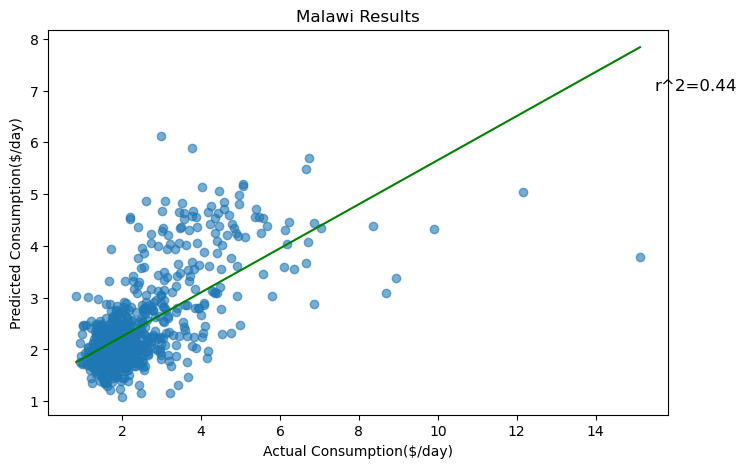

In [25]:
fig = plot_predictions(y_mw, yhat_mw, r2, 'Malawi', max_y=20)

In [26]:
fig.savefig(os.path.join(FIGURES_DIR, 'malawi_results.png'))

In [27]:
plt.savefig('malawi_results.png')

<Figure size 640x480 with 0 Axes>

In [28]:
r2, yhat_eth = run_randomized_cv(x_eth, y_eth, random_seed=RANDOM_SEED, to_print=False)

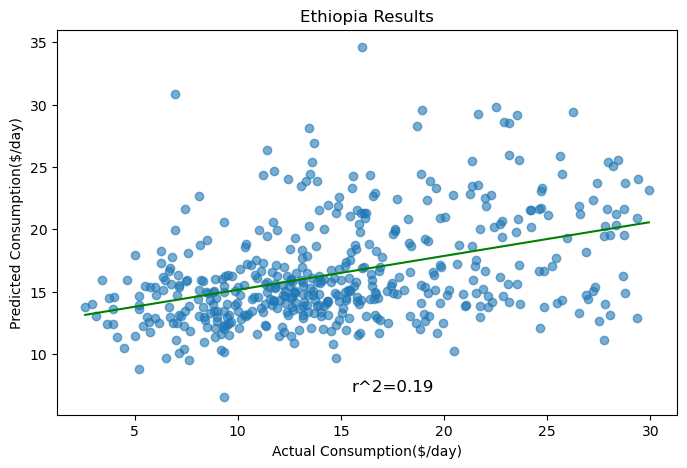

In [29]:
fig = plot_predictions(y_eth, yhat_eth, r2, 'Ethiopia', max_y=30)

In [30]:
fig.savefig(os.path.join(FIGURES_DIR, 'ethiopia_results.png'))

In [31]:
r2, yhat_ng = run_randomized_cv(x_ng, y_ng, random_seed=RANDOM_SEED, to_print=False)

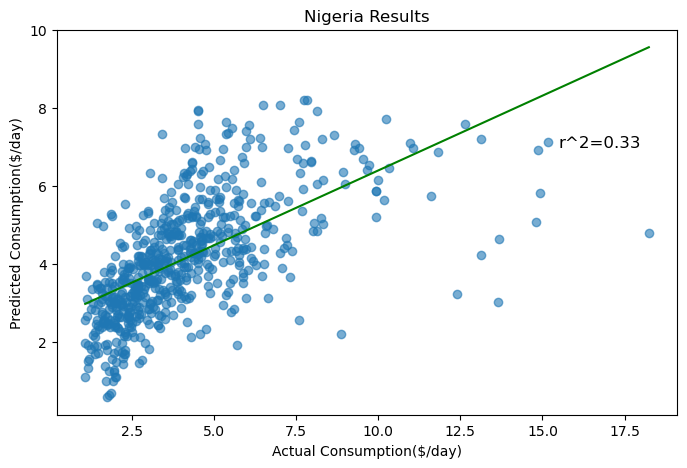

In [32]:
fig = plot_predictions(y_ng, yhat_ng, r2, 'Nigeria', max_y=20)

In [33]:
fig.savefig(os.path.join(FIGURES_DIR, 'nigeria_results.png'))